In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import zipfile
import pubchempy as pcp
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

from util import *

# surechembl vs drugbank

In [9]:
surechembl = pickle_load("../../data/processed/surechembl/250106_surechembl_smiles_date.pickle")
surechembl_smiles = set(surechembl.keys())

In [10]:
df_db = pd.read_csv("../../data/processed/drugbank/250106_drugbank_onlysmiles.csv")
drugbank_smiles = set(df_db["0"])

drugbank = pickle_load("../../data/processed/drugbank/250106_drugbank_smiles_date.pickle")
drugbank_smiles_with_date = set(drugbank.keys())

/opt/250102_test_env/lib/python3.11/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


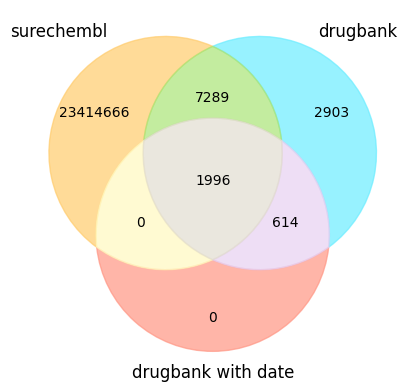

In [13]:
from matplotlib_venn import venn3_unweighted

venn = venn3_unweighted([surechembl_smiles, drugbank_smiles, drugbank_smiles_with_date], ('surechembl', 'drugbank', 'drugbank with date'), alpha=0.7)

venn.get_patch_by_id('100').set_color('#ffcc6d')  
venn.get_patch_by_id('010').set_color('#6bedff')
venn.get_patch_by_id('001').set_color('#ff9684')

venn.get_patch_by_id('110').set_color('#aae577')  
venn.get_patch_by_id('101').set_color('#fff8bf')  
venn.get_patch_by_id('011').set_color('#e7d0f2')

venn.get_patch_by_id('111').set_color('#e2ddd0') 

In [7]:
from tqdm import tqdm
x_db = []
x_sc = []
for i in tqdm(surechembl_smiles):
    if i in drugbank_smiles_with_date:
        x_db.append(drugbank[i])
        x_sc.append(surechembl[i])

100%|██████████| 23423951/23423951 [00:31<00:00, 732348.61it/s] 


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

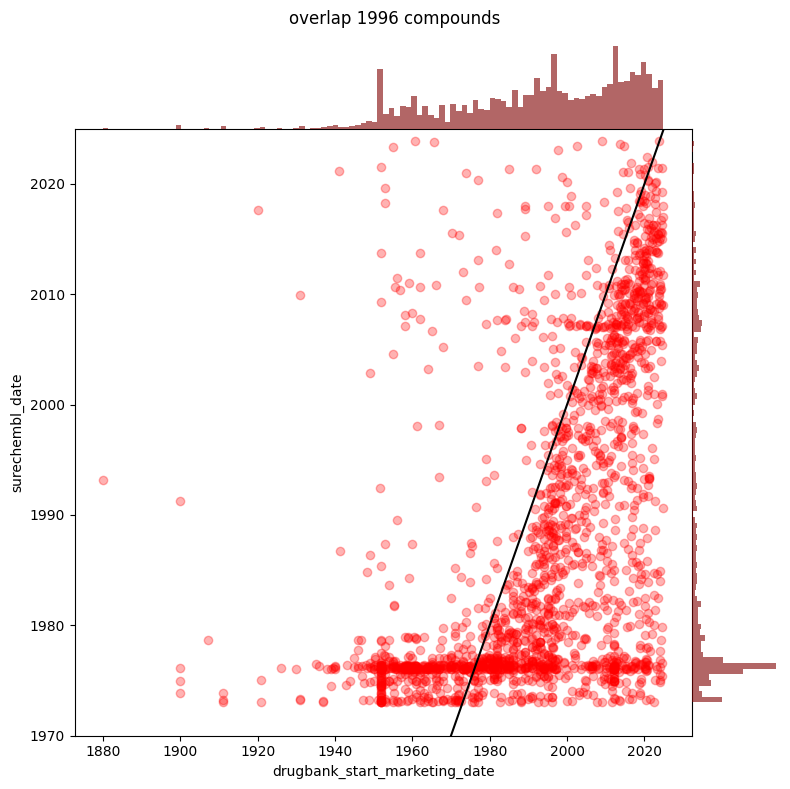

In [9]:
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(8, 8, figure=fig, wspace=0.0, hspace=0.0,)

scatter_ax = fig.add_subplot(gs[1:8, 0:7])
scatter_ax.scatter(x_db, x_sc, alpha=0.3, c="red")
x = np.linspace(1880, 2025 , 1000000)
y = x
scatter_ax.plot(x, y, c="black")
scatter_ax.set_ylim((1970,2025))
scatter_ax.set_xlabel('drugbank_start_marketing_date')
scatter_ax.set_ylabel("surechembl_date")

hist_x_ax = fig.add_subplot(gs[0, 0:7], sharex=scatter_ax)
hist_x_ax.hist(x_db, bins=100, alpha=0.6, color='maroon')
hist_x_ax.axis('off')

hist_y_ax = fig.add_subplot(gs[1:8, 7], sharey=scatter_ax)
hist_y_ax.hist(x_sc, bins=100, orientation='horizontal', alpha=0.6, color='maroon')
hist_y_ax.axis('off')

fig.suptitle(f"overlap {len(x_db)} compounds")
plt.tight_layout()

In [10]:
correlation = np.corrcoef(x_db, x_sc)[0, 1]
print(f"Correlation coefficient: {correlation:.4f}")

# Percentage of compounds whose patents were filed earlier, based on data from 1976 onward when US patent information began to be collected
filtered_indices = [i for i, x in enumerate(x_sc) if x > 1976]
smaller_count = sum(x_sc[i] < x_db[i] for i in filtered_indices)
total_count = len(filtered_indices)
smaller_ratio = smaller_count / total_count
print(f"Ratio of data where Shurechembl is faster than drugbank: {smaller_ratio:.4%}")

Correlation coefficient: 0.5317
Ratio of data where Shurechembl is faster than drugbank: 72.3104%


# surechembl vs drugbank vs molculenet 

In [84]:
# select 1 dataset from ../../data
df_mn_test = pd.read_csv("../../data/processed/moleculenet/moleculenet_patentdate/sider/pre_mol_dataset.tsv", sep="\t", header=None)

mn_test = dict()
for i in range(len(df_mn_test)):
    mn_test[df_mn_test.iloc[i,0]] = df_mn_test.iloc[i,1]

mn_test_smiles = set(mn_test.keys())

/opt/250102_test_env/lib/python3.11/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


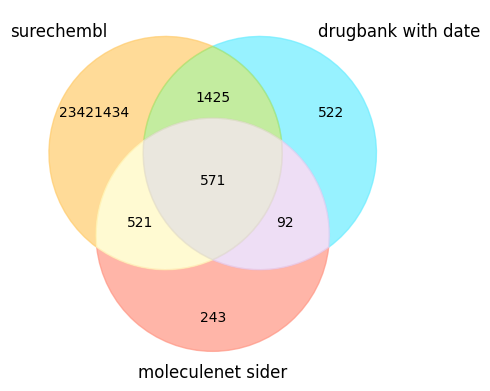

In [ ]:
venn = venn3_unweighted([surechembl_smiles, drugbank_smiles_with_date, mn_test_smiles], ('surechembl', 'drugbank with date', 'moleculenet sider'), alpha=0.7)

venn.get_patch_by_id('100').set_color('#ffcc6d')  
venn.get_patch_by_id('010').set_color('#6bedff')
venn.get_patch_by_id('001').set_color('#ff9684')

venn.get_patch_by_id('110').set_color('#aae577')  
venn.get_patch_by_id('101').set_color('#fff8bf')  
venn.get_patch_by_id('011').set_color('#e7d0f2')

venn.get_patch_by_id('111').set_color('#e2ddd0') 

In [98]:
# about all dataset
import glob
paths = glob.glob("../../data/processed/moleculenet/moleculenet_patentdate/*/pre_mol_dataset.tsv")

overlap_db = []
overlap_sc = []
labels = []

for path in paths:
    df_mn_test = pd.read_csv(path, sep="\t", header=None)
    mn_smiles = set(df_mn_test[0])

    overlap_db.append(len(mn_smiles & drugbank_smiles) / len(mn_smiles) * 100)
    overlap_sc.append(len(mn_smiles & surechembl_smiles) / len(mn_smiles) * 100)
    labels.append(path.replace("../../data/processed/moleculenet/moleculenet_patentdate/", "").replace("/pre_mol_dataset.tsv", ""))

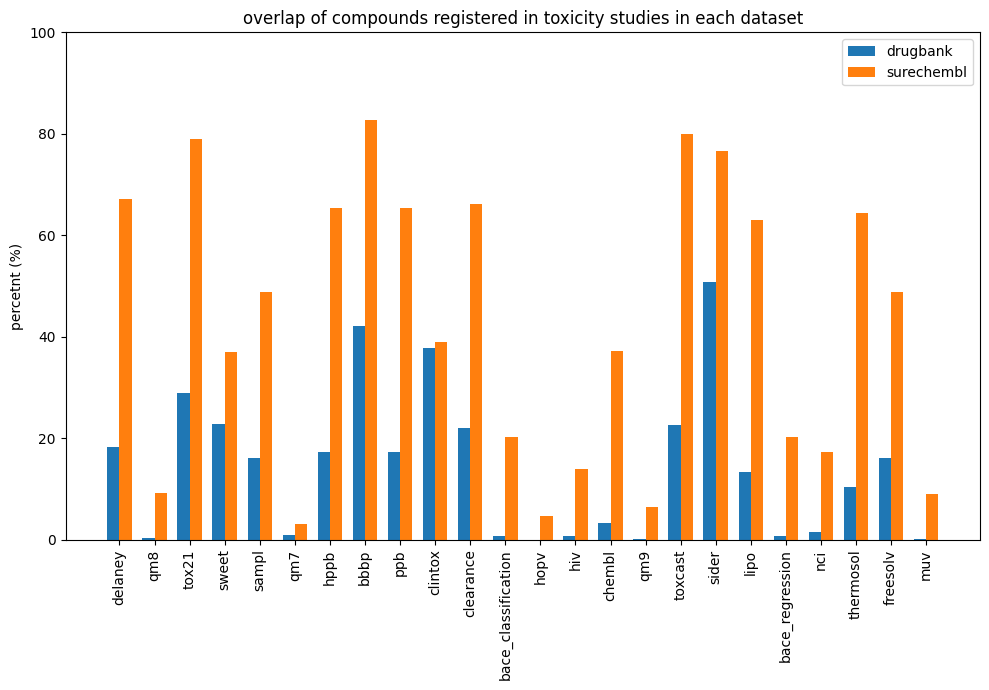

In [ ]:
x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, overlap_db, width, label='drugbank')
rects2 = ax.bar(x + width/2, overlap_sc, width, label='surechembl')

# ax.set_xlabel('Classes')
ax.set_ylabel('percetnt (%)')
ax.set_title('overlap of compounds registered in toxicity studies in moleculenet')
ax.set_xticks(x)
ax.set_ylim((0,100))
ax.set_xticklabels(labels, rotation=90)
ax.legend()

fig.tight_layout()
plt.show()

# surechembl vs drugbank vs tdc

In [3]:
# select 1 dataset from ../../data
df_tdc_test = pd.read_csv("../../data/processed/tdc/Tox/4_hERG_Karim.tsv", sep="\t", index_col=0)

tdc_test = dict()
for i in range(len(df_tdc_test)):
    tdc_test[df_tdc_test.iloc[i,0]] = df_tdc_test.iloc[i,1]

tdc_test_smiles = set(tdc_test.keys())

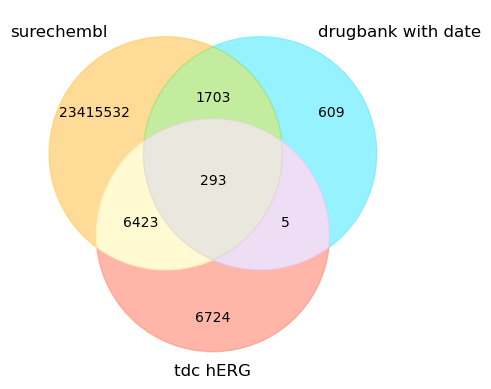

In [12]:
from matplotlib_venn import venn3_unweighted
venn = venn3_unweighted([surechembl_smiles, drugbank_smiles_with_date, tdc_test_smiles], ('surechembl', 'drugbank with date', 'tdc hERG'), alpha=0.7)

venn.get_patch_by_id('100').set_color('#ffcc6d')  
venn.get_patch_by_id('010').set_color('#6bedff')
venn.get_patch_by_id('001').set_color('#ff9684')

venn.get_patch_by_id('110').set_color('#aae577')  
venn.get_patch_by_id('101').set_color('#fff8bf')  
venn.get_patch_by_id('011').set_color('#e7d0f2')

venn.get_patch_by_id('111').set_color('#e2ddd0') 

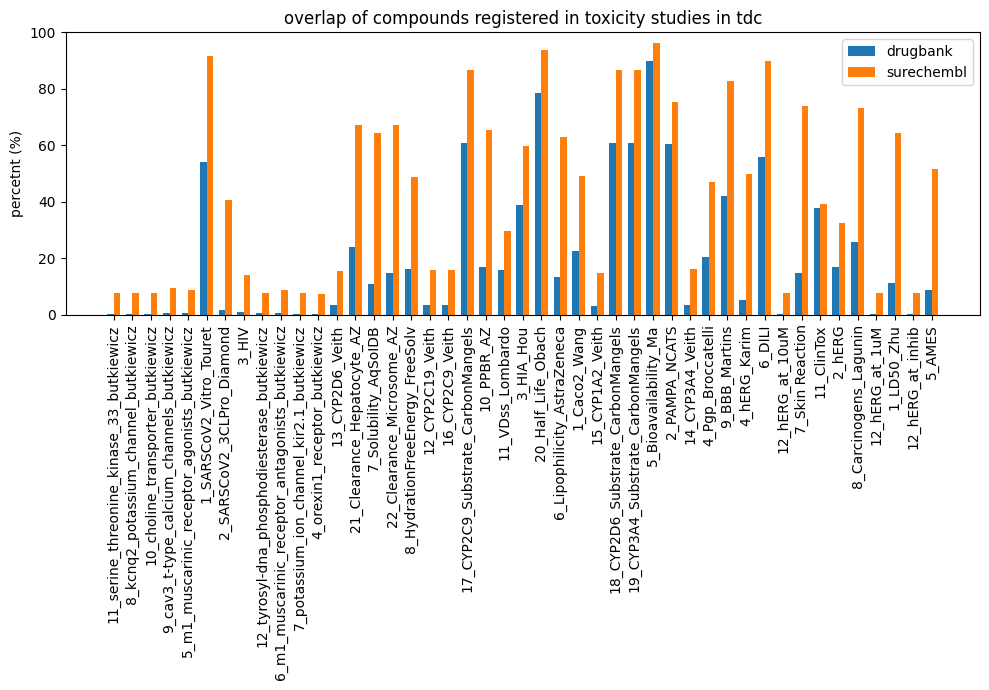

In [106]:
# about full database

paths = glob.glob("../../data/processed/tdc/*/*.tsv")

overlap_db = []
overlap_sc = []
labels = []

for path in paths:
    if "_date" in path:
        continue
    df_mn_test = pd.read_csv(path, sep="\t", index_col=0)
    mn_smiles = set(df_mn_test["0"])

    overlap_db.append(len(mn_smiles & drugbank_smiles) / len(mn_smiles) * 100)
    overlap_sc.append(len(mn_smiles & surechembl_smiles) / len(mn_smiles) * 100)
    labels.append(path.replace("../../data/processed/tdc/", "").replace(".tsv", "").split("/")[1])

x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, overlap_db, width, label='drugbank')
rects2 = ax.bar(x + width/2, overlap_sc, width, label='surechembl')

# ax.set_xlabel('Classes')
ax.set_ylabel('percetnt (%)')
ax.set_title('overlap of compounds registered in toxicity studies in tdc')
ax.set_xticks(x)
ax.set_ylim((0,100))
ax.set_xticklabels(labels, rotation=90)
ax.legend()

fig.tight_layout()
plt.show()